# NN cascade for STKA


# The code  (re-training and evaluation)

### Imports and axiliary functions and stuff

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1,3'
import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

In [1]:
%load_ext sql
%matplotlib inline

In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/jupyter/instantclient_18_3:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64'
os.environ['PATH'] = '/jupyter/instantclient_18_3:/usr/local/mpi/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin'
os.environ['ORACLE_HOME']='/jupyter/instantclient_18_3'

In [2]:
import numpy
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras

In [6]:
%ls -l /jupyter/instantclient_18_3

total 227296
-rw-r--r-- 1 1007 1007      1317 Jun 28  2018 BASIC_README
-rwxr-xr-x 1 1007 1007     40617 Jun 28  2018 adrci*
-rwxr-xr-x 1 1007 1007     57556 Jun 28  2018 genezi*
lrwxrwxrwx 1 root root        45 Nov 18 15:20 libclntsh.so -> /jupyter/instantclient_18_3/libclntsh.so.18.1*
-rwxrwxr-x 1 1007 1007  77879517 Jun 28  2018 libclntsh.so.18.1*
-rwxrwxr-x 1 1007 1007   8348633 Jun 28  2018 libclntshcore.so.18.1*
-r-xr-xr-x 1 1007 1007   3537979 Jun 28  2018 libipc1.so*
-r-xr-xr-x 1 1007 1007    467468 Jun 28  2018 libmql1.so*
-r-xr-xr-x 1 1007 1007   6636088 Jun 28  2018 libnnz18.so*
lrwxrwxrwx 1 1007 1007        15 Jan 30  2019 libocci.so -> libocci.so.18.1*
-rwxrwxr-x 1 1007 1007   2229347 Jun 28  2018 libocci.so.18.1*
-rwxr-xr-x 1 1007 1007 126950232 Jun 28  2018 libociei.so*
-r-xr-xr-x 1 1007 1007    160875 Jun 28  2018 libocijdbc18.so*
-r-xr-xr-x 1 1007 1007    394835 Jun 28  2018 libons.so*
-rwxrwxr-x 1 1007 1007    118171 Jun 28  2018 liboramysql18.so*
drwxr-xr-x 3 1007 10

In [2]:
with open(os.path.join('/','home','hofman','.dbpold.txt'), 'r') as f: password = f.read().strip()

In [3]:
STA = 'STKA'

In [5]:
query = "oracle://hofman[retraining]:%s@dba1091.qandef:1521" % password
%sql $query

UsageError: Line magic function `%sql` not found.


In [40]:
% sql select count(*) from ml_features where sta=STA

UsageError: Line magic function `%sql` not found.


In [4]:
def plot(history, semilog=False):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(history['accuracy'], label='accuracy')
    ax.plot(history['val_accuracy'], label='val_accuracy')
    ax.set_ylabel('accuracy')
    if semilog:
        ax.set_yscale('log')
    plt.legend(loc='best')
    ax = fig.add_subplot(212)
    ax.plot(history['loss'], label='loss')
    ax.plot(history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    if semilog:
        ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

In [2]:
#load data from oracle do pandas
#with open(os.path.join('/','home','hofman','.dbpold.txt'), 'r') as f: password_old = f.read().strip()
password_old = 'gagulek'
import cx_Oracle
connection = cx_Oracle.connect('hofman[retraining]', password_old, 'dba1091.qandef')

DatabaseError: DPI-1047: 64-bit Oracle Client library cannot be loaded: "libclntsh.so: cannot open shared object file: No such file or directory". See https://oracle.github.io/odpi/doc/installation.html#linux for help

In [5]:
#connection.close()

### What is the misclassification rate now for all arrivals in our DB?

* #(class_iphase != class_phase) / (#automatic which are not noise) 

In [6]:
#select from database required numbers
#wrong_type = %sql select count(*) from ml_features where sta=STA and class_phase != class_iphase
#total_number = %sql select count(*) from ml_features where sta=STA and phase!='N' and source!='M'
#print('Percentage of misclassified initial wave types: %3.2f%%' % (wrong_type[0][0]/total_number[0][0]*100))

In [8]:
from datetime import datetime as dt

In [9]:
dt.fromtimestamp(1483228800)

datetime.datetime(2017, 1, 1, 1, 0)

In [10]:
ts_2017 = dt(2017,1,1,0,0,0).timestamp()
ts_2018 = dt(2018,1,1,0,0,0).timestamp()
ts_2019 = dt(2019,1,1,0,0,0).timestamp()

### Dataframes per class phase type - RESTRICTION TO DATA BEFORE 2018

In [137]:
query = f"select * from ml_features where sta='{STA}' and class_phase='regS' and time < {ts_2018} and retime<=1"
df_S_all = pd.read_sql(query, con=connection)

In [138]:
df_S_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,37962741,STKA,1.187930e+09,Sn,regS,Sn,regS,0.0,M,0.500000,...,2.348496,2.155141,2.717578,0.3,0.273750,0.456043,0.193904,0.916166,0.912075,1.464293
1,37949162,STKA,1.188022e+09,P,T,Lg,regS,0.0,M,0.666667,...,3.393164,2.689957,2.689957,-0.4,-0.124333,0.301314,11.243244,1.373209,1.575558,1.774297
2,38128491,STKA,1.188513e+09,P,T,Lg,regS,0.0,M,0.333333,...,2.069752,0.665661,1.520149,0.0,-0.187690,0.237290,0.091610,0.627613,1.041864,0.416667
3,38338502,STKA,1.190183e+09,P,T,Lg,regS,0.0,M,0.444444,...,3.444478,1.273240,0.913128,-0.5,-0.156958,0.282948,0.944123,4.943968,0.462009,0.722558
4,38724474,STKA,1.191975e+09,Lg,regS,Lg,regS,0.0,M,0.588235,...,2.710894,3.529900,3.529900,0.1,-0.123604,0.409944,1.537586,4.411625,1.162837,0.728366


In [139]:
df_S_all.shape

(1119, 25)

In [140]:
query = f"select * from ml_features where sta='{STA}' and class_phase='regP' and time < {ts_2018} and retime<=1"
df_P_all = pd.read_sql(query, con=connection)

In [141]:
df_P_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,61575914,STKA,1.283408e+09,Pn,regP,Pg,regP,0.500,A,0.444444,...,1.870546,0.599377,0.719428,0.6,0.293375,0.340143,0.924220,2.618649,0.565146,0.509667
1,63459062,STKA,1.291030e+09,Pn,regP,Pn,regP,0.475,A,0.222222,...,3.221131,0.308925,0.308925,0.3,0.203417,6.795026,9.890656,1.378999,1.073409,0.251391
2,63468937,STKA,1.291061e+09,Pg,regP,Pg,regP,0.000,A,0.222222,...,3.681893,0.793199,0.459173,0.4,0.221312,0.892191,1.060609,0.992713,0.885562,0.684586
3,63523855,STKA,1.291267e+09,Pn,regP,Pn,regP,0.800,A,0.222222,...,2.727121,0.285870,0.344512,0.7,0.300357,0.634207,0.478616,0.808680,0.387517,0.419420
4,63523856,STKA,1.291267e+09,Px,regP,Pg,regP,0.250,A,0.444444,...,2.685962,0.417849,0.551800,0.6,0.255321,0.222681,0.304506,1.542246,0.447987,0.652520


In [16]:
df_P_all.shape

(1723, 25)

In [145]:
query = f"select * from ml_features where sta='{STA}' and class_phase='T' and time < {ts_2018} and retime<=1"
df_T_all = pd.read_sql(query, con=connection)

In [146]:
df_T_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,5525151,STKA,9.880337e+08,P,T,P,T,0.000000,A,0.333333,...,2.181812,0.190448,0.149119,0.2,0.102000,3.601241,0.658557,0.097867,0.234494,0.144150
1,5525288,STKA,9.880347e+08,P,T,P,T,0.000000,A,0.444444,...,5.972402,0.083586,0.101498,0.3,-0.274000,0.591032,0.120984,0.092644,0.082050,0.096420
2,5526727,STKA,9.880480e+08,P,T,P,T,0.000000,A,0.666667,...,5.440632,0.211600,0.211600,0.2,0.081000,0.150159,0.405730,0.272860,0.204547,0.292827
3,5527754,STKA,9.880606e+08,P,T,P,T,0.349999,A,0.666667,...,4.286809,0.122505,0.122505,0.3,0.172333,1.022422,0.554808,0.109871,0.117258,0.110303
4,8732785,STKA,1.017622e+09,P,T,P,T,0.000000,A,0.444444,...,3.004803,0.115447,0.115447,0.0,0.000000,0.428430,0.630487,0.501843,0.100205,0.206925


In [147]:
df_T_all.shape

(123285, 25)

In [148]:
query = f"select * from ml_features where sta='{STA}' and class_phase='N' and time < {ts_2018}" #  and retime=0"
df_N_all = pd.read_sql(query, con=connection)

In [21]:
df_N_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,102319,STKA,9.301086e+08,N,N,None,N,0.0,A,0.444444,...,1.676647,0.255580,0.255580,0.0,0.0000,0.231993,0.598643,0.471069,0.255277,0.328199
1,102345,STKA,9.301087e+08,N,N,None,N,0.0,A,0.444444,...,2.658390,3.516520,2.253499,0.0,0.0000,0.241002,0.986875,2.106621,0.591515,0.256666
2,102346,STKA,9.301089e+08,N,N,None,N,0.0,A,0.444444,...,1.195303,0.329460,0.973824,0.0,0.0000,0.885078,0.308068,1.727177,0.290626,0.300924
3,102347,STKA,9.301090e+08,N,N,None,N,0.0,A,0.444444,...,5.770905,1.613883,1.613883,0.0,0.0000,0.899696,0.631369,1.651362,0.556392,0.573599
4,102378,STKA,9.301098e+08,N,N,None,N,0.0,A,0.666667,...,2.935123,0.221281,0.221281,0.1,0.0945,0.304084,0.886704,0.397591,0.860885,0.837580


In [22]:
df_N_all.shape

(2636396, 25)

In [23]:
#save to csv
#df_ora.to_csv('URZ_pandas.csv')

In [149]:
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (1119, 25)
regP (1379, 25)
tele (123285, 25)
noise (2636396, 25)


# Definition of input and output

In [150]:
# columns corresponding to input
x_indices = ['PER', 'RECT', 'PLANS', 'INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'NAB', 'TAB',  
             'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5']
print('features count:', len(x_indices))
# columns corresponding to output
y_indices = ['CLASS_PHASE']

metadata = ['ARID','STA','TIME','IPHASE','CLASS_IPHASE','PHASE','CLASS_PHASE','RETIME','SOURCE']

features count: 15


# Dataset for first phase of the cascade: N vs TPS

In [151]:
#counts of all classes
ns = df_S_all.shape[0]
np = df_P_all.shape[0]
nt = df_T_all.shape[0]
nn = df_N_all.shape[0]

#those from automatic
nsa = df_S_all[df_S_all['SOURCE'] != 'M'].shape[0]
npa = df_P_all[df_P_all['SOURCE'] != 'M'].shape[0]
nta = df_T_all[df_T_all['SOURCE'] != 'M'].shape[0]
nna = df_N_all[df_N_all['SOURCE'] != 'M'].shape[0]


#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
samp_count = min(nsa, npa, nta)

nmult = 1
#sample TPS dataset, random_state is a seed
#excelusion of manual arrivals
#ssS = df_S_all[df_S_all['SOURCE'] != 'M'].sample(nmult*nsa, random_state=11, replace=True)
#ssP = df_P_all[df_P_all['SOURCE'] != 'M'].sample(nmult*npa, random_state=13, replace=True)
#ssT = df_T_all[df_T_all['SOURCE'] != 'M'].sample(nmult*nta, random_state=17, replace=True)

ssS = df_S_all.sample(nmult*ns, random_state=11)
ssP = df_P_all.sample(nmult*np, random_state=13)
ssT = df_T_all.sample(nmult*nt, random_state=17)

#ssS = df_S_all.sample(nmult*nt, random_state=11, replace=True)
#ssP = df_P_all.sample(nmult*nt, random_state=13, replace=True)
#ssT = df_T_all.sample(nmult*nt, random_state=17, replace=True)


TPS_data = pd.concat([ssS, ssP, ssT])

#sample noise phases
#N_data = df_N_all.sample(4*nmult*(nsa+npa+nta), random_state=23)
N_data = df_N_all.sample(frac=1, random_state=23)

#lets shuffle dataset
TPS_data = TPS_data.sample(frac=1, random_state=51).reset_index(drop=True)
N_data = N_data.sample(frac=1, random_state=101).reset_index(drop=True)

print(ssS.shape, ssP.shape, ssT.shape)
print(TPS_data.shape)
print(N_data.shape)

(1119, 25) (1379, 25) (123285, 25)
(125783, 25)
(2636396, 25)


### Normalization of data

* normalization according to iwt_nnet.c : iwt_normalize()


In [152]:
# check on positivity of all features which are going to be log10-ed:)
# check TPS data
print('TPS')
print(TPS_data['HVRAT'][TPS_data['HVRAT']<=0])
print(TPS_data['HVRATP'][TPS_data['HVRATP']<=0])
print(TPS_data['HMXMN'][TPS_data['HMXMN']<=0])
print(TPS_data['HTOV1'][TPS_data['HTOV1']<=0])
print(TPS_data['HTOV2'][TPS_data['HTOV2']<=0])
print(TPS_data['HTOV3'][TPS_data['HTOV3']<=0])
print(TPS_data['HTOV4'][TPS_data['HTOV4']<=0])
print(TPS_data['HTOV5'][TPS_data['HTOV5']<=0])
# check NOISE data
print('NOISE')
print(N_data['HVRAT'][N_data['HVRAT']<=0])
print(N_data['HVRATP'][N_data['HVRATP']<=0])
print(N_data['HMXMN'][N_data['HMXMN']<=0])
print(N_data['HTOV1'][N_data['HTOV1']<=0])
print(N_data['HTOV2'][N_data['HTOV2']<=0])
print(N_data['HTOV3'][N_data['HTOV3']<=0])
print(N_data['HTOV4'][N_data['HTOV4']<=0])
print(N_data['HTOV5'][N_data['HTOV5']<=0])

TPS
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)
NOISE
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)


In [153]:
# normalize TPS
TPS_data_norm = TPS_data.copy(deep=True)
TPS_data_norm['INANG1'] /= 90.
TPS_data_norm['INANG3'] /= 90.
TPS_data_norm['HMXMN'] = numpy.log10(TPS_data['HMXMN'])
TPS_data_norm['HVRATP'] = numpy.log10(TPS_data['HVRATP'])
TPS_data_norm['HVRAT'] = numpy.log10(TPS_data['HVRAT'])
TPS_data_norm['HTOV1'] = numpy.log10(TPS_data['HTOV1'])
TPS_data_norm['HTOV2'] = numpy.log10(TPS_data['HTOV2'])
TPS_data_norm['HTOV3'] = numpy.log10(TPS_data['HTOV3'])
TPS_data_norm['HTOV4'] = numpy.log10(TPS_data['HTOV4'])
TPS_data_norm['HTOV5'] = numpy.log10(TPS_data['HTOV5'])

# normalize NOISE
N_data_norm = N_data.copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data['HTOV5'])

### The same for manually added arrivals

In [173]:
import tensorflow.keras.utils
from tensorflow.keras.utils import multi_gpu_model


### Define train/validation ratio

In [155]:
train_validation_split_ratio = 0.95
samp_count_train = int(TPS_data_norm.shape[0] * train_validation_split_ratio)
samp_count_valid = TPS_data_norm.shape[0] - samp_count_train
print('train count=', samp_count_train, 'test count=', samp_count_valid)

train count= 119493 test count= 6290


In [156]:
TPS_train = TPS_data_norm[:samp_count_train]
TPS_valid = TPS_data_norm[samp_count_train:]

samp_count_train_N = int(N_data_norm.shape[0] * train_validation_split_ratio)

N_train = N_data_norm[:samp_count_train_N]
N_valid = N_data_norm[samp_count_train_N:]

print('TPS train:',TPS_train.shape,'TPS valid:',TPS_valid.shape)
print('N train:  ',N_train.shape,  'N valid:  ',N_valid.shape)

TPS train: (119493, 25) TPS valid: (6290, 25)
N train:   (2504576, 25) N valid:   (131820, 25)


In [157]:
120000./(2500000+120000)

0.04580152671755725

### Check interclass balance of TPS

In [158]:
print('T in TPS train:   ', TPS_train[TPS_train['CLASS_PHASE']=='T'].shape)
print('regP in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regP'].shape)
print('regS in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regS'].shape)

print('T in TPS test:    ', TPS_valid[TPS_valid['CLASS_PHASE']=='T'].shape)
print('regP in TPS test: ', TPS_valid[TPS_valid['CLASS_PHASE']=='regP'].shape)
print('regS in TPS test: ', TPS_valid[TPS_valid['CLASS_PHASE']=='regS'].shape)

T in TPS train:    (117125, 25)
regP in TPS train: (1310, 25)
regS in TPS train: (1058, 25)
T in TPS test:     (6160, 25)
regP in TPS test:  (69, 25)
regS in TPS test:  (61, 25)


### Form train and test sets and shuffle

In [159]:
train = pd.concat([TPS_train, N_train]).sample(frac=1, random_state=31).reset_index(drop=True)
valid =  pd.concat([TPS_valid, N_valid]).sample(frac=1, random_state=33).reset_index(drop=True)
#train.apply(pd.to_numeric, errors='ignore')
#test.apply(pd.to_numeric, errors='ignore')

In [21]:
#numpy.savez(f'train_{STA}', train)
#numpy.savez(f'valid_{STA}', valid)

#train = numpy.load('train_STKA.npz')['arr_0']
#valid = numpy.load('valid_STKA.npz')['arr_0']

In [36]:
#d = numpy.load('STKA.npz') 
#train_X=d['train_X'] #, 
#train_Y=d['train_Y']
#valid_X=d['valid_X']
#valid_Y=d['valid_Y']
#train_Y_GT=d['train_Y_GT']
#valid_Y_GT=d['valid_Y_GT']

### Extract features and class labels

In [160]:
metadata

['ARID',
 'STA',
 'TIME',
 'IPHASE',
 'CLASS_IPHASE',
 'PHASE',
 'CLASS_PHASE',
 'RETIME',
 'SOURCE']

In [161]:

train_X = train[x_indices].values.astype(float)
train_Y = train[y_indices]

valid_X = valid[x_indices].values.astype(float)
valid_Y = valid[y_indices]

train_Y_ = numpy.array(numpy.where(train_Y == 'N', 1, 0), dtype=float)
valid_Y_ = numpy.array(numpy.where(valid_Y == 'N', 1, 0), dtype=float)

#convert to categorical
train_Y = keras.utils.to_categorical(train_Y_)
valid_Y = keras.utils.to_categorical(valid_Y_)

valid_metadata = valid[metadata]

print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)
print(valid_metadata.shape)
print('N phases:', train_Y_.sum())

(2624069, 15) (2624069, 2) (138110, 15) (138110, 2)
(138110, 9)
N phases: 2504576.0


### verification, that if node1 < 0.5 => N (nodes start at 1: node1, node2)

In [162]:
train[y_indices+x_indices].head()

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,N,0.666667,0.878189,0.933693,0.123524,0.878780,0.070759,-0.839596,-0.839596,0.2,0.284625,0.182793,-0.044616,-0.224028,-0.132751,-0.185395
1,N,0.666667,0.930855,0.913615,0.224602,0.675412,0.204271,-0.849737,-0.595867,0.0,0.000000,-0.294309,0.042645,-0.164306,-0.511799,-0.244453
2,N,0.666667,0.917077,0.873932,0.080464,0.991789,0.058977,-1.038983,-1.038983,0.0,0.000000,-0.458362,-0.150689,-0.557727,-0.468132,0.163484
3,N,0.444444,0.570494,0.660170,0.649311,0.656250,0.144678,0.164688,-0.056824,0.1,0.324500,-0.323437,-0.166578,-0.322600,0.182900,-0.379841
4,N,0.666667,0.894475,0.867607,0.788956,0.739125,0.155884,0.471783,-0.224377,0.0,0.504500,-0.420740,-0.170037,-0.140049,0.185458,-0.132237


In [163]:
train_Y[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

#### Ground truth for all 4 classes

In [164]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['N', 'regP', 'regS', 'T'])
valid_Y_GT = le.transform(valid[y_indices])
train_Y_GT = le.transform(train[y_indices])
print(le.transform(['N', 'regP', 'regS', 'T']))
train_Y_GT[:200]

[0 2 3 1]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [165]:
X_nans = numpy.isnan(train_X)
X_nans.shape, train_X.shape
train_X
X_nans

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# Neural network N vs TPS

#### This section is based on retime=0 data with 4 times more noise than associated phases

In [166]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

In [174]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model = Sequential()
model.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
adam = Adam(lr=0.0001) #, clipnorm, clipvalue=0.5)

model_gpu = multi_gpu_model(model, gpus=2)

model_gpu.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # adam, sgd
    metrics = ['accuracy'])

Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.


ValueError: To call `multi_gpu_model` with `gpus=2`, we expect the following devices to be available: ['/cpu:0', '/gpu:0', '/gpu:1']. However this machine only has: ['/cpu:0', '/xla_cpu:0']. Try reducing `gpus`.

In [168]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [169]:
hist_keys = ('accuracy', 'val_accuracy', 'loss', 'val_loss')

In [50]:
history = {k : [] for k in hist_keys}

In [170]:
class_weight = {0 : 1.,  # PST 1 to loss
                1: 0.05}  # noise = 0.1 weights to loss

h = model.fit(train_X[:], train_Y[:], 
          epochs=100, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=(valid_X, valid_Y),
          class_weight=class_weight)

history = {k : history[k] + h.history[k] for k in hist_keys}

Train on 2624069 samples, validate on 138110 samples
Epoch 1/100
2624069/2624069 [==============================] - 31s 12us/sample - loss: 0.0510 - accuracy: 0.8248 - val_loss: 0.0433 - val_accuracy: 0.8209
Epoch 2/100
2624069/2624069 [==============================] - 30s 11us/sample - loss: 0.0408 - accuracy: 0.8312 - val_loss: 0.0395 - val_accuracy: 0.8377
Epoch 3/100
 318080/2624069 [==>...........................] - ETA: 25s - loss: 0.0390 - accuracy: 0.8383

KeyboardInterrupt: 

In [79]:
print(train_Y[train_Y[:,0]==1].shape, train_Y[train_Y[:,1]==1].shape)
print(valid_Y[valid_Y[:,0]==1].shape, valid_Y[valid_Y[:,1]==1].shape)

(14467, 2) (374383, 2)
(762, 2) (19705, 2)


In [80]:
valid_Y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

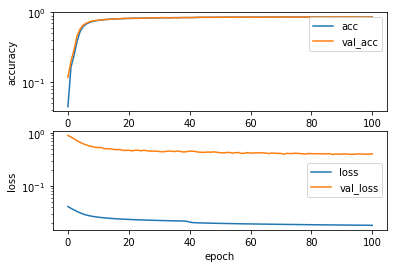

In [81]:
plot(history, semilog=True)

In [82]:
#model = load_model(f'h5/{STA}_NTPS4.h5')

In [171]:
# calculate predicted values
Y_pred_ = model.predict(valid_X)
# predictions are outputted as floats from [0,1]
print(Y_pred_[:10])
print(Y_pred_.shape)
Y_pred = numpy.argmax(Y_pred_, axis=1)
Y_pred[:20]

Y_pred_.sum(axis=1).min(), Y_pred_.sum(axis=1).max()

from sklearn.metrics import confusion_matrix

# we must translate it to 0, 1 based on thresholding at 0.5
# where < 0.5 set to 0, to 1 otherwise
#Y_pred = numpy.where(Y_pred < 0.5, 0, 1)

# calculate confusion matrix
conf_mat = confusion_matrix(Y_pred, valid_Y_)
print(conf_mat)

#[[ 7171 35260]
# [  902 96560]]

[[0.7090374  0.2821274 ]
 [0.11333594 0.8872119 ]
 [0.08375859 0.91794026]
 [0.03751743 0.9612051 ]
 [0.18216234 0.8143332 ]
 [0.11954212 0.884754  ]
 [0.14818084 0.85419613]
 [0.2549783  0.7367173 ]
 [0.11828399 0.8826333 ]
 [0.18775341 0.8058385 ]]
(138110, 2)
[[  4967  20563]
 [  1323 111257]]


In [263]:
#pred_r = numpy.argmax(model.predict(train_X[:]), axis=1)
#train_Y_r = numpy.argmax(train_Y[:], axis=1)
#delta = numpy.abs(pred_r - train_Y_r)
#print(sum(delta))
#d = {1: False, 0: True}

#delta = [d[x] for x in delta]

In [282]:
train_X[:], train_Y[:]
train_X_new = train_X[delta]
train_Y_new = train_Y[delta]
print(train_X_new.shape, train_Y_new.shape, train_X.shape, len(delta))


(625225, 15) (625225, 2) (1088546, 15) 1088546


In [258]:
## confusion matrix on Train?
pred = model.predict(train_X)
#Y_pred = numpy.argmax(, axis=1)
Y_pred = numpy.zeros((pred.shape[0], 1))

#example of threshold other that 0.5:
Y_pred[pred[:,1]>=0.55] = 1

conf_mat = confusion_matrix(Y_pred, train_Y_)
print(conf_mat)

[[ 72739 512402]
 [  3224 500181]]


In [ ]:
[[ 35783  94130]
 [  2027 200218]]

In [55]:
#eval on test data
model.evaluate(valid_X, valid_Y)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.5864308867146444, 0.7418062]

In [88]:
model.evaluate(train_X, train_Y)

388850/388850 [==============================] - 2s 6us/step


[0.39562147985644214, 0.8534859200205734]

In [59]:
#save model and weights, NTC = contextual features correct, Rt => retime <= t seconds
filename = f'h5/{STA}_NTPS1.h5'
model.save(filename)
print(f'saved as filename {filename}')

saved as filename h5/STKA_NTPS1.h5


# Neural network TP vs S 

#### This section is based on retime=2 data

* we need a new dataset for this

## Dataset for TP vs S

In [60]:
print(TPS_train.shape, TPS_valid.shape)

(153383, 25) (8073, 25)


In [61]:
train_X_TPS = TPS_train[x_indices].values.astype(float)
train_Y_TPS = TPS_train[y_indices]

valid_X_TPS = TPS_valid[x_indices].values.astype(float)
valid_Y_TPS = TPS_valid[y_indices]

#regS = 1, T/regP = 0
train_Y_TPS_ = numpy.array(numpy.where(train_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)
valid_Y_TPS_ = numpy.array(numpy.where(valid_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)

#convert to categorical
train_Y_TPS = keras.utils.to_categorical(train_Y_TPS_)
valid_Y_TPS = keras.utils.to_categorical(valid_Y_TPS_)

print(train_X_TPS.shape, train_Y_TPS.shape, valid_X_TPS.shape, valid_Y_TPS.shape)
print('regS:', train_Y_TPS_.sum())
print('regS:', valid_Y_TPS_.sum())

(153383, 15) (153383, 2) (8073, 15) (8073, 2)
regS: 1592.0
regS: 93.0


### test if node3 < 0.5 => S

In [62]:
TPS_train[y_indices+x_indices].head()

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,T,0.333333,0.903252,0.873902,0.846394,0.531904,0.541471,0.543239,0.543239,0.0,0.00000,-0.479135,0.157893,0.286528,-0.308379,0.099270
1,T,0.444444,0.976538,0.982648,0.256820,0.745672,0.378852,-0.929035,-0.929035,0.2,-0.03275,-0.723052,-0.476718,0.161369,-0.948509,-0.627134
2,T,0.444444,0.868589,0.636778,0.448455,0.950716,0.403855,-0.300531,0.150278,0.1,0.04450,-0.575833,-0.066089,-0.187061,-0.619107,0.471905
3,T,0.444444,0.715062,0.703136,0.580711,0.281396,0.355777,-0.099467,0.409886,0.0,0.00000,-0.389415,0.053285,0.248737,-0.500439,-0.348693
4,T,0.444444,0.756955,0.803347,0.680265,0.499387,0.084861,0.039452,-0.029645,0.0,-0.09450,-0.147610,-0.454877,-0.363296,-0.584009,-0.213691


In [63]:
train_Y_TPS[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Neural network

In [64]:
history_TPS = {k : [] for k in hist_keys}

n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TPS = Sequential()
model_TPS.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TPS.add(Dense(2, activation='sigmoid'))

adam = Adam(lr=0.0001)

model_TPS.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # 'adam', 'sgd'
    metrics = ['accuracy'])

In [65]:
model_TPS.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [66]:
class_weight = {0 : 0.005,  # PT is five times more abundant
                1: 1.}  # S = 1 weights to loss
h = model_TPS.fit(train_X_TPS[:], train_Y_TPS[:], 
          epochs=100, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([valid_X_TPS, valid_Y_TPS]),
          class_weight=class_weight)

history_TPS = {k : history_TPS[k] + h.history[k] for k in hist_keys}

Train on 153383 samples, validate on 8073 samples
Epoch 1/100
153383/153383 [==============================] - 2s 16us/sample - loss: 0.0094 - accuracy: 0.0104 - val_loss: 0.0094 - val_accuracy: 0.0115
Epoch 2/100
153383/153383 [==============================] - 2s 12us/sample - loss: 0.0088 - accuracy: 0.0106 - val_loss: 0.0088 - val_accuracy: 0.0125
Epoch 3/100
153383/153383 [==============================] - 2s 12us/sample - loss: 0.0082 - accuracy: 0.0206 - val_loss: 0.0083 - val_accuracy: 0.0371
Epoch 4/100
153383/153383 [==============================] - 2s 12us/sample - loss: 0.0077 - accuracy: 0.0749 - val_loss: 0.0077 - val_accuracy: 0.1387
Epoch 5/100
153383/153383 [==============================] - 2s 11us/sample - loss: 0.0072 - accuracy: 0.2092 - val_loss: 0.0073 - val_accuracy: 0.2915
Epoch 6/100
153383/153383 [==============================] - 2s 11us/sample - loss: 0.0068 - accuracy: 0.3600 - val_loss: 0.0069 - val_accuracy: 0.4226
Epoch 7/100
153383/153383 [===========

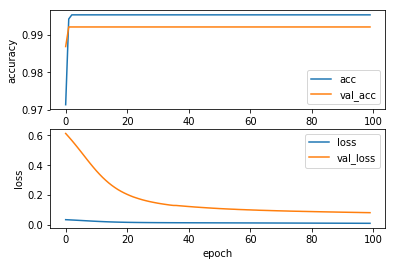

In [101]:
plot(history_TPS)

In [69]:
#NC = nodes correct
model_TPS.save(f'h5/{STA}_TPS.h5')

In [67]:
model_TPS.evaluate(valid_X_TPS, valid_Y_TPS)

8073/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4450667797300905, 0.8182212]

In [118]:
min(valid_Y_TPS_), max(valid_Y_TPS_)
valid_Y_TPS_.shape
sum(valid_Y_TPS_)

6.0

#### Test data confusion matrix

In [68]:
Y_pred = numpy.reshape(numpy.argmax(model_TPS.predict(valid_X_TPS), axis=1), (valid_X_TPS.shape[0],1))
print(Y_pred.shape)
# calculate confusion matrix
C = confusion_matrix(Y_pred, valid_Y_TPS_)
print(C)

(8073, 1)
[[6515    6]
 [1465   87]]


In [70]:
print(valid_X_TPS.shape)
print(valid_Y_TPS.shape)
print(valid_Y_TPS_.shape)
print(min(Y_pred), max(Y_pred))
print(min(valid_Y_TPS_), max(valid_Y_TPS_))
print(sum(valid_Y_TPS_), sum(Y_pred))

(8073, 15)
(8073, 2)
(8073,)
[0] [1]
0.0 1.0
93.0 [1552]


In [71]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 81.78%


# Neural network T vs regP 

#### This section is based on retime=2 data

* we need a new dataset for this

### Dataset for T vs regP

In [72]:
#exclude regS
TP_train = TPS_train[TPS_train['CLASS_PHASE'] != 'regS']
TP_valid  = TPS_valid [TPS_valid ['CLASS_PHASE'] != 'regS']

In [73]:
train_X_TP = TP_train[x_indices].values.astype(float)
train_Y_TP = TP_train[y_indices]

valid_X_TP = TP_valid[x_indices].values.astype(float)
valid_Y_TP = TP_valid[y_indices]

#regS = 0, T/regP = 1
train_Y_TP_ = numpy.array(numpy.where(train_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)
valid_Y_TP_ = numpy.array(numpy.where(valid_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)

#convert to categorical
train_Y_TP = keras.utils.to_categorical(train_Y_TP_)
valid_Y_TP = keras.utils.to_categorical(valid_Y_TP_)

print(train_X_TP.shape, train_Y_TP.shape, valid_X_TP.shape, valid_Y_TP.shape)
print(sum(train_Y_TP_))

(151791, 15) (151791, 2) (7980, 15) (7980, 2)
1634.0


### test if node5 < 0.5 => P

In [74]:
TP_train[y_indices + x_indices].head()

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,T,0.333333,0.903252,0.873902,0.846394,0.531904,0.541471,0.543239,0.543239,0.0,0.00000,-0.479135,0.157893,0.286528,-0.308379,0.099270
1,T,0.444444,0.976538,0.982648,0.256820,0.745672,0.378852,-0.929035,-0.929035,0.2,-0.03275,-0.723052,-0.476718,0.161369,-0.948509,-0.627134
2,T,0.444444,0.868589,0.636778,0.448455,0.950716,0.403855,-0.300531,0.150278,0.1,0.04450,-0.575833,-0.066089,-0.187061,-0.619107,0.471905
3,T,0.444444,0.715062,0.703136,0.580711,0.281396,0.355777,-0.099467,0.409886,0.0,0.00000,-0.389415,0.053285,0.248737,-0.500439,-0.348693
4,T,0.444444,0.756955,0.803347,0.680265,0.499387,0.084861,0.039452,-0.029645,0.0,-0.09450,-0.147610,-0.454877,-0.363296,-0.584009,-0.213691


In [75]:
train_Y_TP[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Neural network

In [76]:
history_TP = {k : [] for k in hist_keys}
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TP = Sequential()
model_TP.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TP.add(Dense(2, activation='sigmoid'))

adam = Adam(lr=0.0001)

model_TP.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # 'adam', sgd
    metrics = ['accuracy'])

In [104]:
class_weight = {0 : 0.01,  # T is several times more abundant
                1: 1}  # P
h = model_TP.fit(train_X_TP[:], train_Y_TP[:], 
          epochs=1, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([valid_X_TP, valid_Y_TP]),
          class_weight=class_weight)

history_TP = {k : history_TP[k] + h.history[k] for k in hist_keys}

Train on 151791 samples, validate on 7980 samples
151791/151791 [==============================] - 2s 12us/sample - loss: 0.0055 - accuracy: 0.8954 - val_loss: 0.0046 - val_accuracy: 0.8997


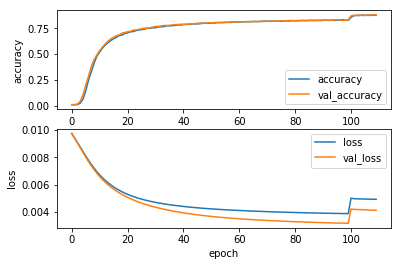

In [85]:
plot(history_TP)

In [106]:
filename = f'h5/{STA}_TP1.h5'
model_TP.save(filename)
print(f'saved as {filename}')

saved as h5/STKA_TP1.h5


In [186]:
model_TP.evaluate(valid_X_TP, valid_Y_TP)

756/756 [==============================] - 0s 9us/step


[0.11868368917041355, 0.9603174609481973]

#### Test data confusion matrix

In [105]:
Y_pred = numpy.reshape(numpy.argmax(model_TP.predict(valid_X_TP), axis=1), (valid_X_TP.shape[0],1))

# calculate confusion matrix
conf_mat = confusion_matrix(Y_pred, valid_Y_TP_)
print(conf_mat)

[[7094    3]
 [ 797   86]]


In [ ]:
[[624 102]
 [ 87 251]]

In [498]:
pred_r = numpy.argmax(model.predict(train_X_TP[:]), axis=1)
train_Y_TP_r = numpy.argmax(train_Y_TP[:], axis=1)
delta_TP = numpy.abs(pred_r - train_Y_TP_r)
print(sum(delta_TP))
d = {1: False, 0: True}

delta_TP = [d[x] for x in delta_TP]
print(len(delta_TP), train_X_TP.shape)

9069
75009 (75009, 15)


# Cascade of all three models

In [108]:
%ls -l h5/

total 140
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 15:39 STKA_NTPS1.h5
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 14:28 STKA_NTPS.h5
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 15:55 STKA_TP1.h5
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 15:53 STKA_TP.h5
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 15:47 STKA_TPS.h5


In [110]:
from tensorflow.keras.models import load_model

In [111]:
model_NTPS = load_model(f'h5/{STA}_NTPS1.h5')
model_STP = load_model(f'h5/{STA}_TPS.h5')
model_PT = load_model(f'h5/{STA}_TP1.h5')

In [112]:
def predict_iwt(X, stage=0):
    """
    predicts initial wave type for given featrue vectors
    Class encoding generated by sklearn Label Encoder
    0 - noise
    2 - regS 
    1 - regP
    3 - T
    """
    Y = numpy.arange(X.shape[0])
    
    N_indices = None
    S_indices = None 
    
    if stage >= 1:
        N_indices = [False] * X.shape[0]
        X_PTS = X
        Y_NPTS = numpy.zeros(X.shape[0])
    if stage >= 2:
        S_indices =  [False] * X.shape[0]  # numpy.array([])
        X_PT = X
        Y_PTS = numpy.zeros(X.shape[0])
        
    
    """
    N vs regS, regP, T
    """
    if N_indices is None:
        #predict N vs T,regP,regS
        Y_NPTS = numpy.argmax(model_NTPS.predict(X), axis=1)
        #set which are noise
        N_indices = Y[Y_NPTS == 1]  #  = 0
        #get candidates for TPS
        X_PTS = X[Y_NPTS < 1]
    else:
        print('Skipping N, classifying TPS only')

    """
    regS vs regP, T
    """
    if S_indices is None:    
        #predict regS vs T,regP
        Y_PTS = numpy.argmax(model_STP.predict(X_PTS), axis=1)
        #set which are regS
        S_indices = Y[Y_NPTS < 1][Y_PTS == 1]  # = 2
        #get candidates for regP,T
        X_PT = X_PTS[Y_PTS < 1]
    else:
        print('Skipping N, regS, classifying TP only')

    """
    regP vs T
    """
    #predict regP vs T
    Y_PT = numpy.argmax(model_PT.predict(X_PT), axis=1)
    #set which are regP
    P_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT == 1]  # = 1    
    #set which are T
    T_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT < 1]   # = 3
    #get those which are T
    X_T = X_PT[Y_PT < 1]
    
    Y[N_indices] = 0 # 0 # N
    Y[S_indices] = 3 # 2 # regS
    Y[P_indices] = 2 # 1 # regP 
    Y[T_indices] = 1 # 3 # tele
    
    return Y
    

In [113]:
Y = predict_iwt(valid_X)

### Overall confusion matrix for test data

In [114]:
valid_X.shape, Y.shape, valid_Y_GT.shape

((139893, 15), (139893,), (139893,))

In [115]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(Y, valid_Y_GT)
print(C)

[[100080    795      3     68]
 [ 18758   5934      1      5]
 [  1247    337     45      1]
 [ 11735    825     40     19]]


In [116]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Assoc accuracy: %3.2f%%' % ((numpy.diag(C)[1:].sum())/(C[:,1:].sum())*100))
print('Overal accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (C[0,1:].sum()/C[:,1:].sum()*100))

Assoc accuracy: 74.30%
Overal accuracy: 75.83%
N phase rate: 10.73%


### Test data just regS, regP, T - not to be confused with overall statistics on all arrivals in our DB

In [208]:
valid_TPS = valid[valid['CLASS_PHASE'] != 'N']
valid_TPS_X = valid_TPS[x_indices]
valid_TPS_pred_Y = predict_iwt(valid_TPS_X)
valid_TPS_truth_Y = le.transform(valid_TPS['CLASS_PHASE'])
valid_TPS_iphase_Y = le.transform(valid_TPS['CLASS_IPHASE'])

In [209]:
valid_TPS_iphase_Y.min(), valid_TPS_iphase_Y.max()

(0, 3)

In [210]:
print('IPHASE:')
C = confusion_matrix(valid_TPS_iphase_Y, valid_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (C[0,1:].sum()/C[:,1:].sum()*100))

IPHASE:
[[  0   3   0   1]
 [  0 681   0   4]
 [  0  48   2   1]
 [  0  22   0   0]]
Accuracy: 89.63%
N phase rate: 0.52%


In [211]:
print('NEW PREDICTION')
C = confusion_matrix(valid_TPS_pred_Y, valid_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (C[0,1:].sum()/C[:,1:].sum()*100))

NEW PREDICTION
[[  0  73   0   2]
 [  0 658   0   0]
 [  0  11   2   1]
 [  0  12   0   3]]
Accuracy: 87.01%
N phase rate: 9.84%


* in the test data, the current iwt characterized 166 as NOISE (first row of confusion matrix)
* our new iwt would characterize 49 as NOISE
* after re-training, accuracy on the test set rose from 59.14% to 71.53% for regS, regP and T phases

# Prediction on 2018 - today

### Load data

In [117]:
query = f"select * from ml_features where sta='{STA}' and class_phase='regS' and time > {ts_2018}" #" and time < {ts_2019}"
df_S_2017 = pd.read_sql(query, con=connection)
query = f"select * from ml_features where sta='{STA}' and class_phase='regP' and time > {ts_2018}" #" and time < {ts_2019}"
df_P_2017 = pd.read_sql(query, con=connection)
query = f"select * from ml_features where sta='{STA}' and class_phase='T' and time > {ts_2018}" #" and time < {ts_2019}"
df_T_2017 = pd.read_sql(query, con=connection)
query = f"select * from ml_features where sta='{STA}' and class_phase='N' and time > {ts_2018}" #" and time < {ts_2019}"
df_N_2017 = pd.read_sql(query, con=connection)
print(df_S_2017.shape, df_P_2017.shape, df_T_2017.shape, df_N_2017.shape)

(126, 25) (96, 25) (15230, 25) (253563, 25)


In [118]:
data_2017 = pd.concat([df_P_2017, df_S_2017, df_T_2017])
data_2017_wN = pd.concat([df_P_2017, df_S_2017, df_T_2017, df_N_2017])

In [119]:
test_TPS_iphase_Y_2017 = le.transform(data_2017['CLASS_IPHASE'])

In [120]:
data_2017_X = data_2017[x_indices]

data_2017_norm = data_2017[x_indices].copy(deep=True)
data_2017_norm['INANG1'] /= 90.
data_2017_norm['INANG3'] /= 90.
data_2017_norm['HMXMN'] = numpy.log10(data_2017_X['HMXMN'])
data_2017_norm['HVRATP'] = numpy.log10(data_2017_X['HVRATP'])
data_2017_norm['HVRAT'] = numpy.log10(data_2017_X['HVRAT'])
data_2017_norm['HTOV1'] = numpy.log10(data_2017_X['HTOV1'])
data_2017_norm['HTOV2'] = numpy.log10(data_2017_X['HTOV2'])
data_2017_norm['HTOV3'] = numpy.log10(data_2017_X['HTOV3'])
data_2017_norm['HTOV4'] = numpy.log10(data_2017_X['HTOV4'])
data_2017_norm['HTOV5'] = numpy.log10(data_2017_X['HTOV5'])

data_2017_X_wN = data_2017_wN[x_indices]

data_2017_norm_wN = data_2017_wN[x_indices].copy(deep=True)
data_2017_norm_wN['INANG1'] /= 90.
data_2017_norm_wN['INANG3'] /= 90.
data_2017_norm_wN['HMXMN'] = numpy.log10(data_2017_X_wN['HMXMN'])
data_2017_norm_wN['HVRATP'] = numpy.log10(data_2017_X_wN['HVRATP'])
data_2017_norm_wN['HVRAT'] = numpy.log10(data_2017_X_wN['HVRAT'])
data_2017_norm_wN['HTOV1'] = numpy.log10(data_2017_X_wN['HTOV1'])
data_2017_norm_wN['HTOV2'] = numpy.log10(data_2017_X_wN['HTOV2'])
data_2017_norm_wN['HTOV3'] = numpy.log10(data_2017_X_wN['HTOV3'])
data_2017_norm_wN['HTOV4'] = numpy.log10(data_2017_X_wN['HTOV4'])
data_2017_norm_wN['HTOV5'] = numpy.log10(data_2017_X_wN['HTOV5'])

In [121]:
data_2017_Y = numpy.zeros(data_2017.shape[0])
data_2017_Y[:df_P_2017.shape[0]] = 2
data_2017_Y[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 3
data_2017_Y[df_P_2017.shape[0]+df_S_2017.shape[0]:] = 1

data_2017_Y_wN = numpy.zeros(data_2017_wN.shape[0])
data_2017_Y_wN[:df_P_2017.shape[0]] = 2
data_2017_Y_wN[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 3
data_2017_Y_wN[df_P_2017.shape[0]+df_S_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]+df_T_2017.shape[0]] = 1

### Predict and evaluate

In [130]:
model_NTPS = load_model(f'h5/{STA}_NTPS1.h5')
model_STP = load_model(f'h5/{STA}_TPS.h5')
model_PT = load_model(f'h5/{STA}_TP1.h5')

In [131]:
data_2017_pred = predict_iwt(data_2017_norm)
data_2017_pred_wN = predict_iwt(data_2017_norm_wN)
print(data_2017_norm.shape[0], data_2017_norm_wN.shape[0])

15452 269015


In [132]:
C = confusion_matrix(data_2017_pred, data_2017_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
nphaserate = C[0,:].sum()/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (nphaserate*100))

[[    0  1379     6    85]
 [    0 11313     8     5]
 [    0   805    42     7]
 [    0  1733    40    29]]
Accuracy: 73.67%
N phase rate: 9.51%


In [133]:
C = confusion_matrix(data_2017_pred_wN, data_2017_Y_wN)
print(C)
diagsum = numpy.diag(C).sum()
tot_accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (tot_accuracy*100))

[[211090   1379      6     85]
 [ 21320  11313      8      5]
 [  1657    805     42      7]
 [ 19496   1733     40     29]]
Accuracy: 82.70%


In [294]:
summary = "Training summary: Accuracy: %3.2f%%, assoc accuracy: %3.2f%%, Nphaserate: %3.2f%%, assoc. ph: %d, noise ph: %d" % (tot_accuracy*100, accuracy*100, nphaserate*100, data_2017_norm.shape[0], data_2017_norm_wN.shape[0])
print(summary)

Training summary: Accuracy: 69.49%, assoc accuracy: 88.28%, Nphaserate: 4.75%, assoc. ph: 4564, noise ph: 89253


In [288]:
 data_2017_Y_wN.shape

(89253,)

In [289]:
print('N', data_2017_Y_wN[data_2017_Y_wN==0].shape)
print('P', data_2017_Y_wN[data_2017_Y_wN==1].shape)
print('S', data_2017_Y_wN[data_2017_Y_wN==2].shape)
print('T', data_2017_Y_wN[data_2017_Y_wN==3].shape)

N (84689,)
P (4520,)
S (31,)
T (13,)


## Overall results on train data just to see if it works...

In [290]:
Y = predict_iwt(train_X)
C = confusion_matrix(Y, train_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[279677    678      1      9]
 [ 76021  12662     16     14]
 [  9220    535     46     10]
 [  9465    460      2     34]]
Accuracy: 75.20%


# Let's analyze weights and generate a new NN weight file!

In [295]:
model_NTPS = load_model(f'h5/{STA}_NTPS3.h5')
model_STP = load_model(f'h5/{STA}_TPS.h5')
model_PT = load_model(f'h5/{STA}_TP3.h5')

In [296]:
weights_NTPS = model_NTPS.get_weights()
weights_STP = model_STP.get_weights()
weights_PT = model_PT.get_weights()

In [297]:
model_NTPS.get_config()

[{'class_name': 'Dense',
  'config': {'name': 'dense_3',
   'trainable': True,
   'batch_input_shape': (None, 15),
   'dtype': 'float32',
   'units': 6,
   'activation': 'sigmoid',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'bias_constraint': None}},
 {'class_name': 'Dense',
  'config': {'name': 'dense_4',
   'trainable': True,
   'units': 2,
   'activation': 'sigmoid',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'bias_regulari

In [298]:
for w in weights_NTPS:
    print(w.shape)
    print(w)

(15, 6)
[[ 5.39013386e-01  2.25521922e-01  2.23776746e+00 -1.07817054e+00
  -1.15928747e-01  2.07208082e-01]
 [ 8.20597470e-01 -6.15893245e-01  5.48022151e-01 -1.23845315e+00
   1.04215407e+00  9.53306317e-01]
 [-1.00914669e+00  7.39625096e-01 -1.36606431e+00  5.08746922e-01
  -9.34596956e-01 -1.30655169e+00]
 [ 3.35461950e+00 -3.47453570e+00  1.19238329e+00 -3.48980665e+00
   3.15453100e+00  3.50542307e+00]
 [-2.40331006e+00  2.64676118e+00 -2.04779720e+00  2.38927627e+00
  -2.05806994e+00 -1.97148120e+00]
 [-1.34742785e+00  2.96481460e-01  7.46449113e-01  6.63989425e-01
  -3.74425650e-01 -1.21242130e+00]
 [-2.44479084e+00  1.77178395e+00 -1.72121078e-01  1.38810658e+00
  -1.73807514e+00 -2.15348315e+00]
 [-8.18378210e-01  3.11606795e-01  3.62809122e-01 -5.58490932e-01
  -9.03446823e-02 -9.21620607e-01]
 [ 3.29828644e+00 -3.55615664e+00  5.14193964e+00 -4.20699453e+00
   3.63224554e+00  3.37219000e+00]
 [-1.26887345e+00  1.33915377e+00 -7.67389417e-01  5.38579285e-01
  -1.15343463e+00

In [299]:
for w in weights_STP:
    print(w.shape)
    print(w)

(15, 6)
[[-0.11140002 -0.5366431   0.08567722 -0.01669007 -0.15058166 -0.23840511]
 [-0.44803798  0.04160155 -0.4203899   0.17094679 -0.04569538 -0.284765  ]
 [-0.21832806 -0.6027057  -0.44686216 -0.03605173  0.0025421  -0.5378558 ]
 [-0.9317382  -0.6000893  -0.8275146   0.11902345 -0.9112676  -0.42336342]
 [-0.47981858  0.27152506 -0.41937253  0.5129954   0.04948828 -0.05625184]
 [-0.77997315 -0.36424252  0.15148236  0.84623563  0.00508904 -0.61305624]
 [-0.8462165  -0.39265743 -0.17093897  0.36221418 -0.6097382  -0.6872306 ]
 [-0.92969114 -0.40701523 -0.3079271   0.59024197 -0.622065   -1.1366501 ]
 [-0.18410745 -0.59983003  0.22221565  0.9348056  -0.33208355 -0.17126824]
 [ 0.1633076   0.512511   -0.07821102 -0.19903612 -0.03094362 -0.42958617]
 [ 0.1405612  -0.7375202  -0.53777     0.07678484 -0.03723213  0.18104577]
 [-0.57409465 -0.5137815  -0.5544532   0.27206084 -0.10841064 -0.44923958]
 [-0.52062345 -0.50484437 -0.64441925  0.7123631   0.07019989 -0.26025763]
 [-0.25889385 -0.

In [300]:
for w in weights_PT:
    print(w.shape)
    print(w)

(15, 6)
[[-0.8822706  -1.7073393   1.6208196  -1.7564578  -1.1809386  -1.1564008 ]
 [ 0.8451349   1.2798741  -0.29779056  0.92810893  1.0622554   0.98869   ]
 [ 1.1806048   0.76203495 -0.3380259   0.8600919   1.2271183   0.84496474]
 [ 1.7720156   2.1020033  -0.22438483  1.8191283   1.5430858   2.2376406 ]
 [-0.00898787  0.6910061  -0.74635965  0.5695406   0.32174245  0.39985734]
 [-1.2061105  -0.7301194   1.7343472  -0.47920865 -0.7791533  -1.0017127 ]
 [ 0.959917    1.5160973   1.0348631   1.1737876   1.0427186   1.1752033 ]
 [ 0.935346    1.4920876   4.470706    1.090883    0.979317    0.704481  ]
 [ 2.6606393   1.5785142  -2.4220164   2.6164827   2.2888086   2.5401073 ]
 [ 1.4932896   1.4189557  -2.271318    0.9158238   1.1967494   1.0286183 ]
 [ 0.16783081 -0.09682177 -0.01512582  0.12154402  0.06918313  0.1689054 ]
 [ 0.8128436   0.78478116 -0.5789018   0.7131385   0.93387973  0.89898384]
 [ 1.377678    1.1577234   2.2603512   1.3867918   1.5255929   1.5475217 ]
 [ 1.8997551   0.

### Let's export it to a weigth file using a template

In [301]:
station_name = STA

In [302]:
# open template
with open(os.path.join('../templates','weight_file.template')) as f:
    template = f.read()
    #print(template)

In [303]:
import datetime
#put name to template
s = template.replace('{{station_name}}', station_name)
s = s.replace('{{date}}', datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))
s = s.replace('{{training_summary}}', summary)

In [304]:
weight_idents = ('TPSN', 'TPS', 'TP')
weights = (weights_NTPS, weights_STP, weights_PT)

In [305]:
#prepare weights
for ident, w in zip(weight_idents, weights):
    weights_layer_1 = ""
    for i in range(w[0].shape[0]):
        weights_layer_1 += ' '.join(list(map(lambda x: "%7.6f" % x, w[0][i,:])))
        if i < w[0].shape[0] - 1:
            weights_layer_1  += '\n'        
        
    bias_layer_1 = ' '.join(list(map(lambda x: "%7.6f" % x, w[1])))
    
    weights_layer_2 = ""
    for i in range(w[2].shape[0]):
        weights_layer_2 += ' '.join(list(map(lambda x: "%7.6f" % x, w[2][i,:])))
        if i < w[2].shape[0] - 1:
            weights_layer_2  += '\n'        
        
    bias_layer_2 = ' '.join(list(map(lambda x: "%7.6f" % x, w[3])))
    
    #put coefficients into template
    s = s.replace('{{%s_bias_layer_1}}' % ident, bias_layer_1) 
    s = s.replace('{{%s_weights_layer_1}}' % ident, weights_layer_1)
    s = s.replace('{{%s_bias_layer_2}}' % ident, bias_layer_2)
    s = s.replace('{{%s_weights_layer_2}}' % ident, weights_layer_2)
    
#print(bias_layer_1)
#print(weights_layer_1)
#print(bias_layer_2)
#print(weights_layer_2)

In [306]:
print(s)

*-- NRIK.nn
*-- Comments ...
*-- Auxiliary 3C station NRIK uses the new weights from retraining by RH
*-- Generated 2019/11/13 09:54:38
*-- Training summary: Accuracy: 69.49%, assoc accuracy: 88.28%, Nphaserate: 4.75%, assoc. ph: 4564, noise ph: 89253
NRIK
3
60.000000
  0.25   0.50   1.00   2.00   4.00
NRIK TPS-N
628 3 16 7 2
-1.630639 1.937722 -1.781763 1.663452 -1.800555 -1.648663
0.539013 0.225522 2.237767 -1.078171 -0.115929 0.207208
0.820597 -0.615893 0.548022 -1.238453 1.042154 0.953306
-1.009147 0.739625 -1.366064 0.508747 -0.934597 -1.306552
3.354620 -3.474536 1.192383 -3.489807 3.154531 3.505423
-2.403310 2.646761 -2.047797 2.389276 -2.058070 -1.971481
-1.347428 0.296481 0.746449 0.663989 -0.374426 -1.212421
-2.444791 1.771784 -0.172121 1.388107 -1.738075 -2.153483
-0.818378 0.311607 0.362809 -0.558491 -0.090345 -0.921621
3.298286 -3.556157 5.141940 -4.206995 3.632246 3.372190
-1.268873 1.339154 -0.767389 0.538579 -1.153435 -1.418314
-0.180212 -0.234345 0.045993 -0.305129 0.03

In [307]:
#save it
with open(os.path.join('nn_weights','%s.nn' % station_name), 'w+') as f:
    f.write(s)

### Experiment if the weight from C code gives the same results as here

arid=119744643 
 
Before normalization:
(1.000000,0.966347,0.977263,8.234518,88.750600,2.412571,0.044210,0.044210,0.300000,0.507750,1.166405,0.288975,0.655635,0.703711,0.243465) nab=0.300000 tab=0.507750

Normalized: 
(1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563) nab=0.300000 tab=0.507750

results of stages in C code (StaPro):
+++++ TPS-N: arid=119744643  node1=0.667373 node2=0.332627
+++++ TP-S: arid=119744643  node3=0.991951 node4=0.007760
+++++ T-P: arid=119744643  node5=0.862848 node6=0.137152


In [133]:
input = numpy.reshape(numpy.array([1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563]), (1,15))
print('TPS-N:', model_NTPS.predict(input))
print('TP-S :', model_STP.predict(input))
print('T-P  :', model_PT.predict(input))

TPS-N: [[0.66737413 0.3326257 ]]
TP-S : [[0.9919511  0.00776022]]
T-P  : [[0.86284804 0.13715191]]


# URZ DVL evaluation after one month

* we let the new NN classifier run for more than one month and than analysed the data (2018/07/25-2018/09/04)
* 3251 arrivals in total, 370 associated of that
* arrivals in IDCDEV and ODB are paired by proximity in time and azimuth to be sure

In [127]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

In [16]:
query = """select * from urz_eval_oct2"""
urz_eval = pd.read_sql(query, con=connection)

In [17]:
urz_eval

,ARID_DEV,ARID_ODB,TIME_DEV,TIME_ODB,AZI_DEV,AZI_ODB,IPHASE_DEV,IPHASE_ODB,ASSOC_PHASE,CLASS_IPHASE_DEV,CLASS_IPHASE_ODB,CLASS_PHASE_ODB,NCLS_IPHASE_DEV,NCLS_IPHASE_ODB,NCLS_PHASE_ODB
0,126374191,134713582,1.534748e+09,1.534748e+09,356.882510,356.882510,P,P,P,T,T,T,3,3,3
1,126375785,134715306,1.534753e+09,1.534753e+09,12.079766,12.079792,P,N,P,T,N,T,3,0,3
2,126376162,134715666,1.534755e+09,1.534755e+09,347.864520,347.864530,P,P,P,T,T,T,3,3,3
3,126379946,134718854,1.534764e+09,1.534764e+09,348.731750,348.731750,P,P,P,T,T,T,3,3,3
4,126379947,134718855,1.534764e+09,1.534764e+09,344.056190,344.056190,Sx,Sx,S,regS,regS,T,2,2,3
5,126380309,134719333,1.534765e+09,1.534765e+09,38.220733,38.220719,P,P,P,T,T,T,3,3,3
6,126381080,134720125,1.534767e+09,1.534767e+09,50.938620,50.938665,P,N,P,T,N,T,3,0,3
7,126384271,134723901,1.534779e+09,1.534779e+09,355.845540,355.845600,P,P,P,T,T,T,3,3,3
8,126385494,134725045,1.534784e+09,1.534784e+09,348.251760,348.251770,P,P,P,T,T,T,3,3,3
9,126387228,134726675,1.534790e+09,1.534790e+09,7.380147,7.380175,P,N,P,T,N,T,3,0,3


In [18]:
from sklearn.metrics import confusion_matrix

### Confusion matrix with new weights

In [19]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_DEV'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[2042    3    8   11]
 [ 503   84    1   60]
 [ 719    2   83   64]
 [ 485    8    0  170]]
Accuracy: 56.07%


In [136]:
numpy.diag(C)/C.sum(axis=0)

array([0.54467858, 0.86597938, 0.90217391, 0.55737705])

In [137]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.6821862348178138

In [134]:
#August:

### Confusion matrix with old weights

In [138]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_ODB'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[1879    9   33   48]
 [ 497   76    2   83]
 [ 439    2   56   39]
 [ 934   10    1  135]]
Accuracy: 50.58%


In [139]:
numpy.diag(C)/C.sum(axis=0)

array([0.50120032, 0.78350515, 0.60869565, 0.44262295])

In [140]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.5404858299595142

In [141]:
#August:

In [142]:
C.sum()

4243

# URZ TST evaluation after some time

* we let the new NN classifier run for more than one month and than analysed the data (2018/10/09-2018/11/20)
* 3412 arrivals in total, 336 associated of that
* arrivals in TST and ODB are paired by proximity in time and azimuth to be sure

In [7]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

In [20]:
query = """select * from urz_eval_tst"""
urz_eval = pd.read_sql(query, con=connection)

In [21]:
urz_eval

,ARID_DEV,ARID_ODB,TIME_DEV,TIME_ODB,AZI_DEV,AZI_ODB,IPHASE_DEV,IPHASE_ODB,ASSOC_PHASE,CLASS_IPHASE_DEV,CLASS_IPHASE_ODB,CLASS_PHASE_ODB,NCLS_IPHASE_DEV,NCLS_IPHASE_ODB,NCLS_PHASE_ODB
0,163155867,135993887,1.539090e+09,1.539090e+09,94.184126,94.184126,Lg,Sx,None,regS,regS,N,2,2,0
1,163158494,135997160,1.539099e+09,1.539099e+09,157.894260,157.894260,N,P,None,N,T,N,0,3,0
2,163158495,135997161,1.539099e+09,1.539099e+09,90.380756,90.380756,N,P,None,N,T,N,0,3,0
3,163158496,135997162,1.539099e+09,1.539099e+09,141.813570,141.813570,P,N,None,T,N,N,3,0,0
4,163158497,135997163,1.539099e+09,1.539099e+09,337.098900,337.098900,P,N,None,T,N,N,3,0,0
5,163159717,135998298,1.539103e+09,1.539103e+09,67.040294,67.040239,N,P,None,N,T,N,0,3,0
6,163160579,135999173,1.539105e+09,1.539105e+09,240.753160,240.753160,N,P,None,N,T,N,0,3,0
7,163161374,135999686,1.539107e+09,1.539107e+09,345.969390,345.969390,Pn,Pn,P,regP,regP,T,1,1,3
8,163161375,135999687,1.539107e+09,1.539107e+09,342.179640,342.179600,Px,N,None,regP,N,N,1,0,0
9,163161376,135999688,1.539107e+09,1.539107e+09,77.486684,77.487341,Pn,N,None,regP,N,N,1,0,0


In [43]:
from sklearn.metrics import confusion_matrix

### Confusion matrix with new weights

In [33]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_DEV'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100), C.sum())

[[1626    1    4    8]
 [ 341   46    1   38]
 [ 489    1   51   47]
 [ 459    6    1  132]]
Accuracy: 57.06% 3251


In [29]:
numpy.diag(C)/C.sum(axis=0)

array([0.55780446, 0.85185185, 0.89473684, 0.58666667])

### accuracy associated

In [30]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.6815476190476191

### Confusion matrix with old weights

In [31]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_ODB'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[1470    6   22   29]
 [ 380   44    5   55]
 [ 342    1   30   29]
 [ 723    3    0  112]]
Accuracy: 50.94%


### accuracy associated

In [32]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.5535714285714286